# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [37]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "ana-class100_0168_s2"   # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Batch_Size = 32
Epoch_Anz = 400
input_shape = (32,32,3)

##########################################################################



from absl import app as absl_app
from absl import flags
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

FileName = TFliteNamingAndVersion + "_qs" + ".tflite"


loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)


### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [38]:
Input_dir='data_resize_all'

files = glob.glob("data_raw_all" + '/*.jpg')
y_data = np.empty((len(files)))
f_data = np.empty((len(files)), dtype="<U250")
x_data = np.empty((len(files),input_shape[0],input_shape[1],input_shape[2]))

for i, aktfile in enumerate(files):
    base = os.path.basename(aktfile)

    # get label from filename (1.2_ new or 1_ old),
    if (base[1]=="."):
        target = base[0:3]
    else:
        target = base[0:1]
    category = float(target)
    
    test_image = Image.open(aktfile).resize((input_shape[0],input_shape[1]), Image.Resampling.NEAREST)
    test_image = np.array(test_image, dtype="float32")
    f_data[i] =  aktfile
    x_data[i] = test_image
    y_data[i] =  category
print("Analog data count: ", len(y_data))  

#x_data = np.array(x_data).astype(np.floa<t32)
#y_data = np.array(y_data)
#y_data = np.expand_dims(y_data, -1)#.astype(np.int8)
print(x_data.shape)

x_data, y_data, f_data = shuffle(x_data, y_data, f_data)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
y_train = keras.utils.to_categorical(y_train*10, 100)
y_test = keras.utils.to_categorical(y_test*10, 100)

print(np.expand_dims(y_data, axis=1).shape)



Analog data count:  6898
(6898, 32, 32, 3)
(6898, 1)


### Distribution of the data

Uneven distribution of data can lead to poorer results.

In some classes (8.4) we have only 20 images. In other classes over 100 images.

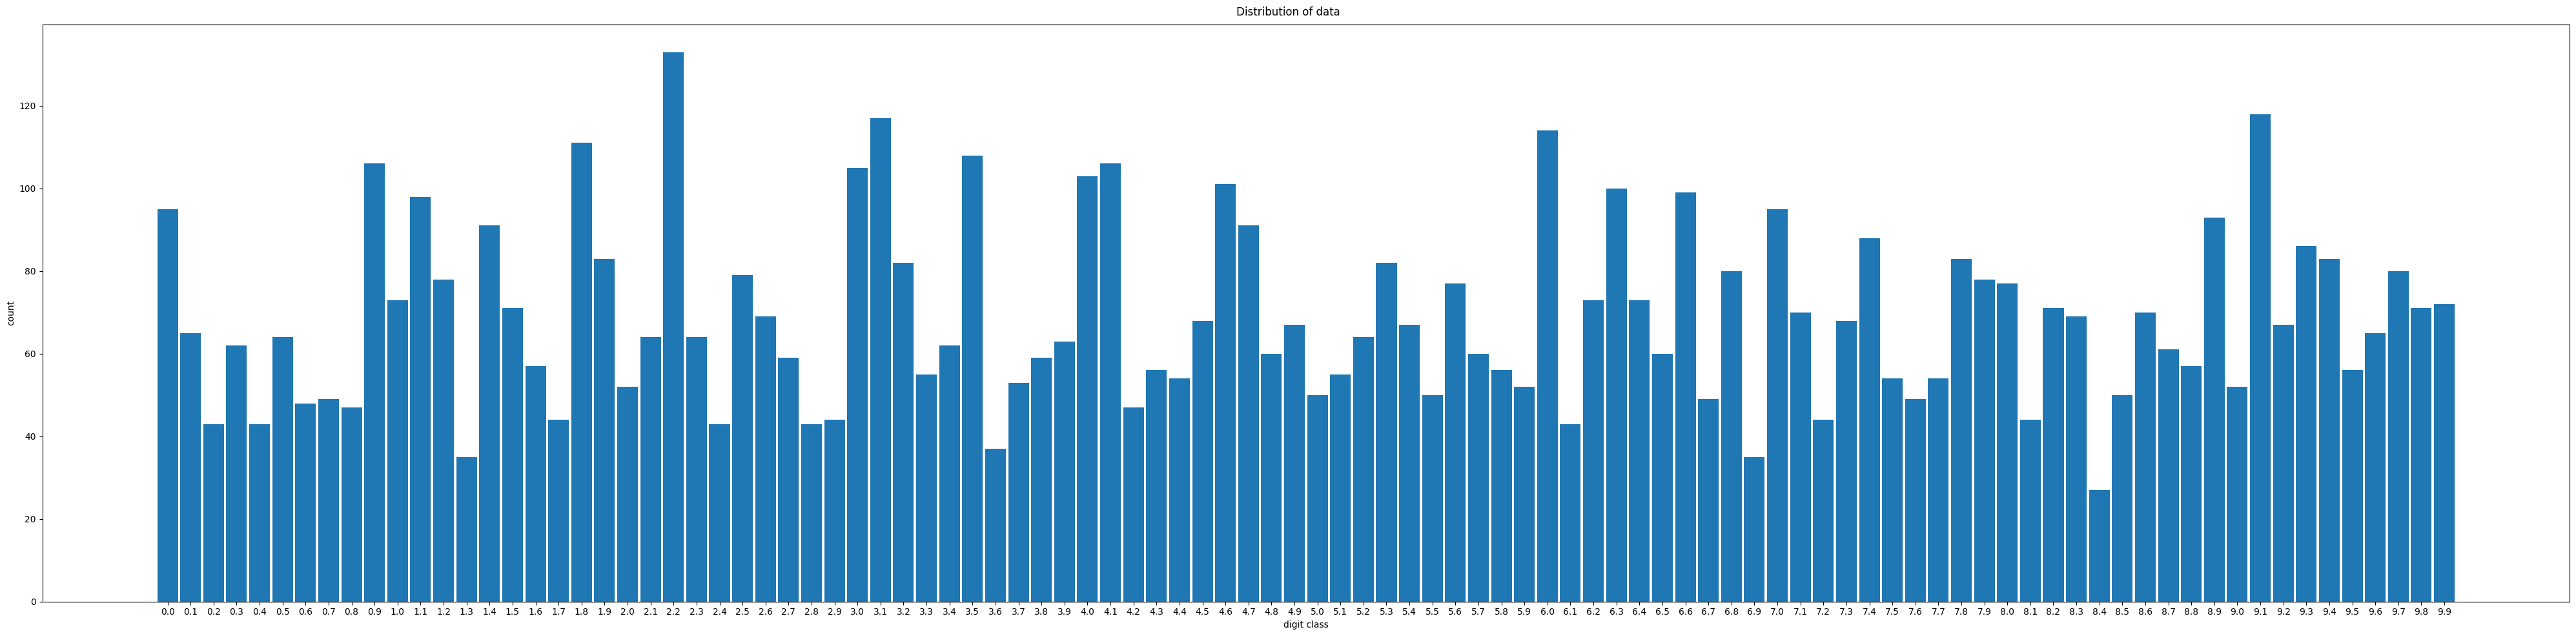

In [39]:
_, inverse = np.unique(y_data, return_inverse=True)
ziffer_bincount = np.bincount(inverse)
fig = plt.figure(figsize=(40, 10))
fig.suptitle("Distribution of data")
plt.bar(np.arange (0, 100/10, 0.1), ziffer_bincount, width=0.09, align='center')
plt.ylabel('count')
plt.xlabel('digit class')
plt.tight_layout()
_ = plt.xticks(np.arange(0, 100/10, 0.1))


### Define the model

The layout of the network ist a typcial CNN network with alternating 2x **Conv2D**, **BatchNormalization** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

**Dropout** between CNN layers are 0.2, between fully connected layers 0.4, but only the fully connected output layer.

* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (100) - classification 0.0 ... 9.9

In [40]:


inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.BatchNormalization()(inputs)

x = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation="relu")(x)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Conv2D(32, (1, 1), padding='same', activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(4,4))(x)
x = tf.keras.layers.Dropout(0.15)(x)

x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.15)(x)
x = tf.keras.layers.Conv2D(48, (3, 3), padding='same', activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(4,4))(x)
x = tf.keras.layers.Dropout(0.15)(x)

x = tf.keras.layers.Conv2D(48, (3, 3), padding='same', activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.15)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Dropout(0.15)(x)

x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
#
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(100)(x)

model = tf.keras.Model(inputs=inputs, outputs=output)


model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.legacy.Adam(
    learning_rate=1e-3), metrics = ["accuracy"])
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 batch_normalization_24 (Bat  (None, 32, 32, 3)        12        
 chNormalization)                                                
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 batch_normalization_25 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                           

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is in one step. 

The best model will be stored as \<modelname\>_best.h5

### Augmentation

Augmentation uses shift, zoom, brightness, shear

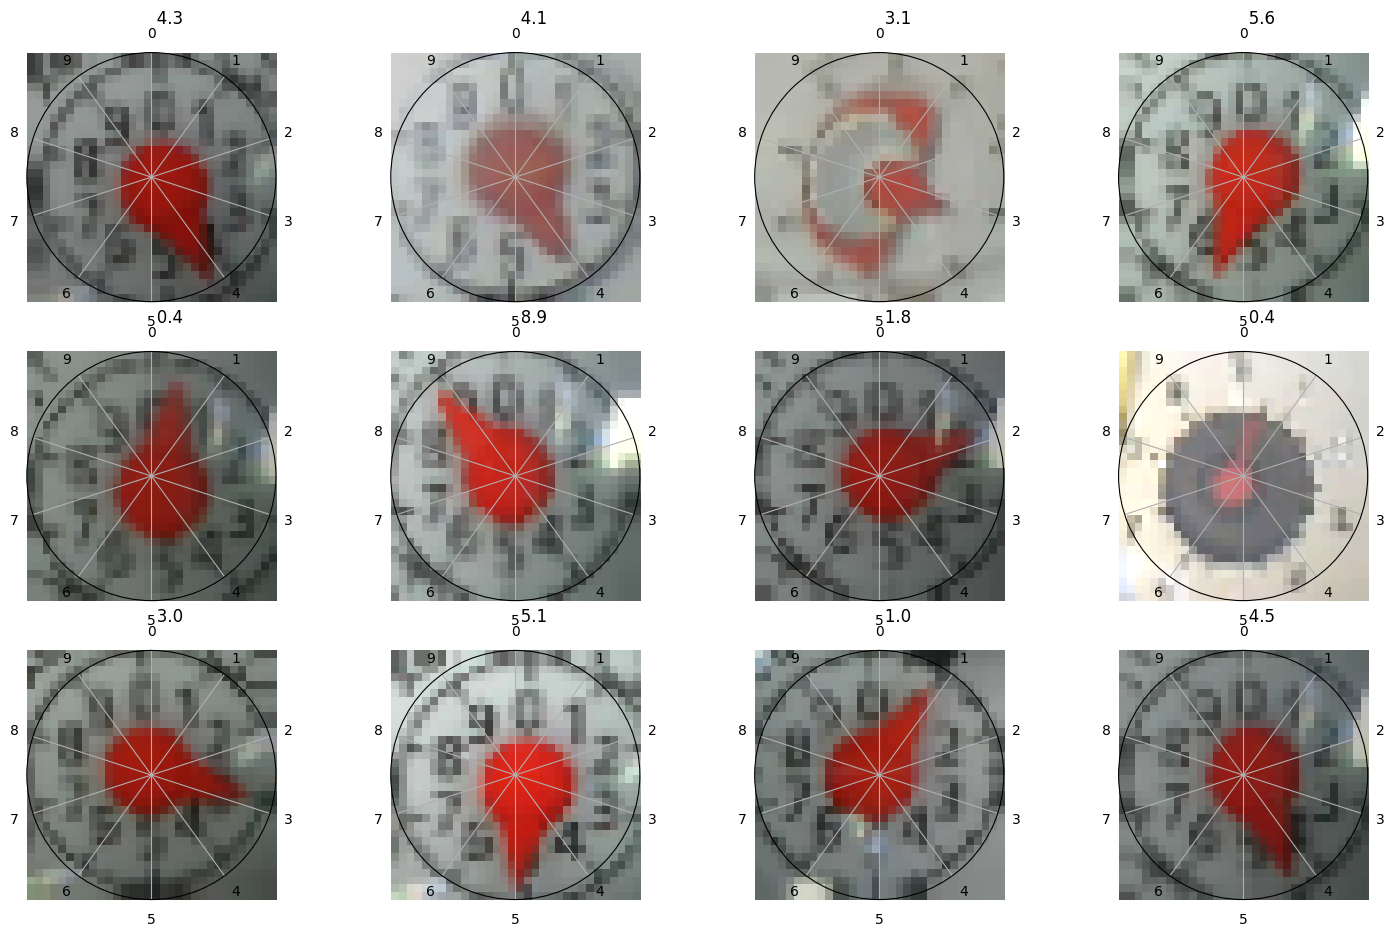

In [41]:
from numpy import pi
import random

Shift_Range = 1/32
Zoom_Range = 0.05
Brightness_Range = 0.3
ShearRange= 3
Rotation_Range=2

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 3
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                height_shift_range=[-Shift_Range,Shift_Range],
                brightness_range=[1-Brightness_Range,1+Brightness_Range],
                zoom_range=Zoom_Range,
                shear_range=ShearRange,
                rotation_range=Rotation_Range,
                #preprocessing_function=add_noise
                #rescale=1/255
                )
datagen_val = ImageDataGenerator()
train_iterator = datagen.flow(X_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen_val.flow(X_test, y_test, batch_size=Batch_Size)


columns=4
rows=3

fig = plt.figure(figsize=(18, 11))
for i in range(1, columns*rows +1):
    img, label = train_iterator.next()
    ax0 = fig.add_subplot(rows, columns, i)
    target = (np.argmax(label[0])/10)
    plt.title("{:10.1f}\n".format(target))  # set title
    plt.imshow(img[0].astype(np.uint8))
    plt.axis('off')
    ax=plt.gca()
    ax.get_xaxis().set_visible(False) 
    ax2 = fig.add_subplot(rows, columns, i, polar=True, label="polar")
    ax2.set_facecolor("None")
    # suppress the radial labels
    plt.setp(ax.get_yticklabels(), visible=False)

    # set the circumference labels
    ax2.set_xticks(np.linspace(0, 2*pi, 10, endpoint=False))
    ax2.set_xticklabels(range(10))
    ax2.yaxis.grid(False)
    
    # make the labels go clockwise
    ax2.set_theta_direction(-1)
    # place 0 at the top
    ax2.set_theta_offset(pi/2.0)    
    ax2.set_yticklabels([])


    # plt.grid('off')

    # put the points on the circumference
    plt.ylim(0,1)
plt.show()


In [42]:
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
earlystop = EarlyStopping(monitor='val_loss', mode='min' , patience=30, verbose=1,  restore_best_weights=True)
mc = ModelCheckpoint(TFliteNamingAndVersion + '_best.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True, initial_value_threshold=.9)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=1e-5, verbose=1)
history = model.fit(train_iterator, 
            validation_data=validation_iterator, 
            batch_size=Batch_Size, 
            epochs = Epoch_Anz,
            callbacks=[earlystop, mc, reduce_lr],
            verbose=1)


Epoch 1/400


2023-04-28 22:09:23.138070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


172/173 [============================>.] - ETA: 0s - loss: 4.6055 - accuracy: 0.0164

2023-04-28 22:09:28.187259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss did not improve from 0.90000
173/173 [==============================] - 6s 31ms/step - loss: 4.6055 - accuracy: 0.0165 - val_loss: 4.5765 - val_accuracy: 0.0217 - lr: 0.0010
Epoch 2/400
173/173 [==============================] - ETA: 0s - loss: 4.4869 - accuracy: 0.0299
Epoch 2: val_loss did not improve from 0.90000
173/173 [==============================] - 5s 27ms/step - loss: 4.4869 - accuracy: 0.0299 - val_loss: 4.3303 - val_accuracy: 0.0732 - lr: 0.0010
Epoch 3/400
172/173 [============================>.] - ETA: 0s - loss: 3.9398 - accuracy: 0.0798
Epoch 3: val_loss did not improve from 0.90000
173/173 [==============================] - 5s 26ms/step - loss: 3.9368 - accuracy: 0.0803 - val_loss: 3.1925 - val_accuracy: 0.1319 - lr: 0.0010
Epoch 4/400
171/173 [============================>.] - ETA: 0s - loss: 3.0638 - accuracy: 0.1426
Epoch 4: val_loss did not improve from 0.90000
173/173 [==============================] - 5s 26ms/step - loss: 3.0584 - accuracy: 0.

### Learing result
 
* Visualization of the training and validation results
* Validation should not much over train validation, because of the augmentation of train data (validation data not)
* Beware, the best model will be used. This can be from an earlier epoch as the last. (mostly the last -30)


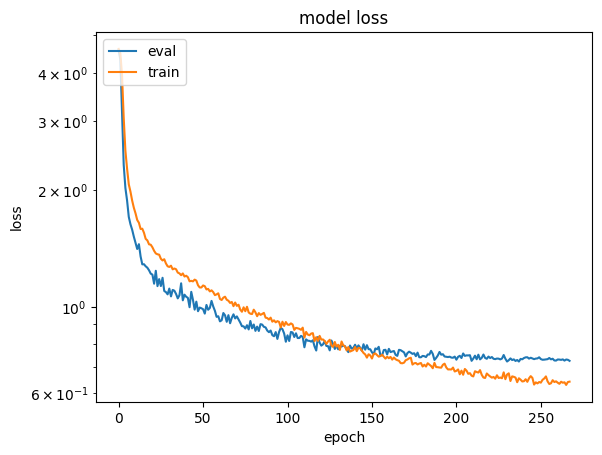

In [43]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)

plt.semilogy(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['eval','train'], loc='upper left')
plt.show()

### Check the model by data

* The following code uses the trained model to check the deviation for each picture (train + validation).
* The max_delta can be used to get the accuracy with allowed differences (for instance +/- 0.1)
* The first (max) 49 false predicted images will be shown
* a csv-file with all false predicted images will be created. It can be used for relabeling. Usage `python3 -m collectmeteranalog  --labelfile=ana-class100_s1_false_predicted.csv --model=ana-class100_s1q.tflite` (see https://github.com/haverland/collectmeteranalog)


 24/216 [==>...........................] - ETA: 0s

2023-04-28 22:31:42.904800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


216/216 [==============================] - 1s 4ms/step
Tested images: 6898. 57 false predicted. Accuracy is: 0.99173673528559


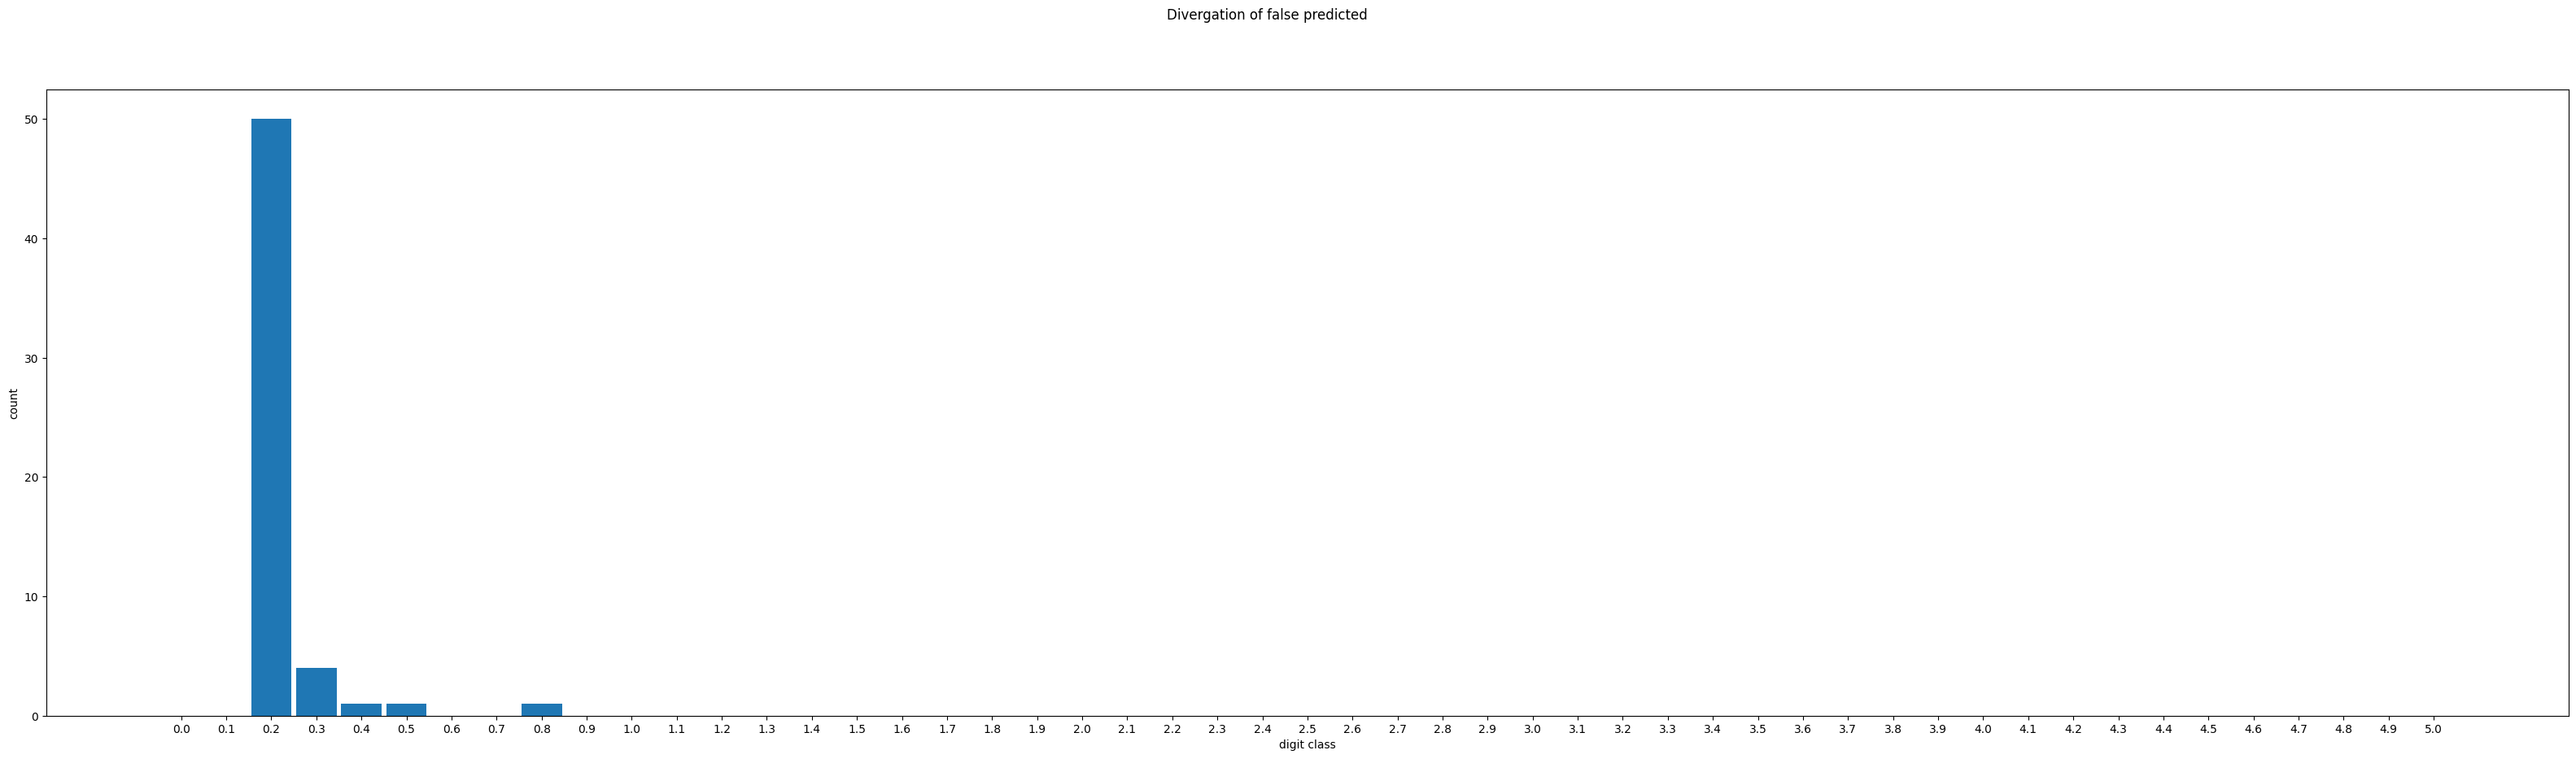

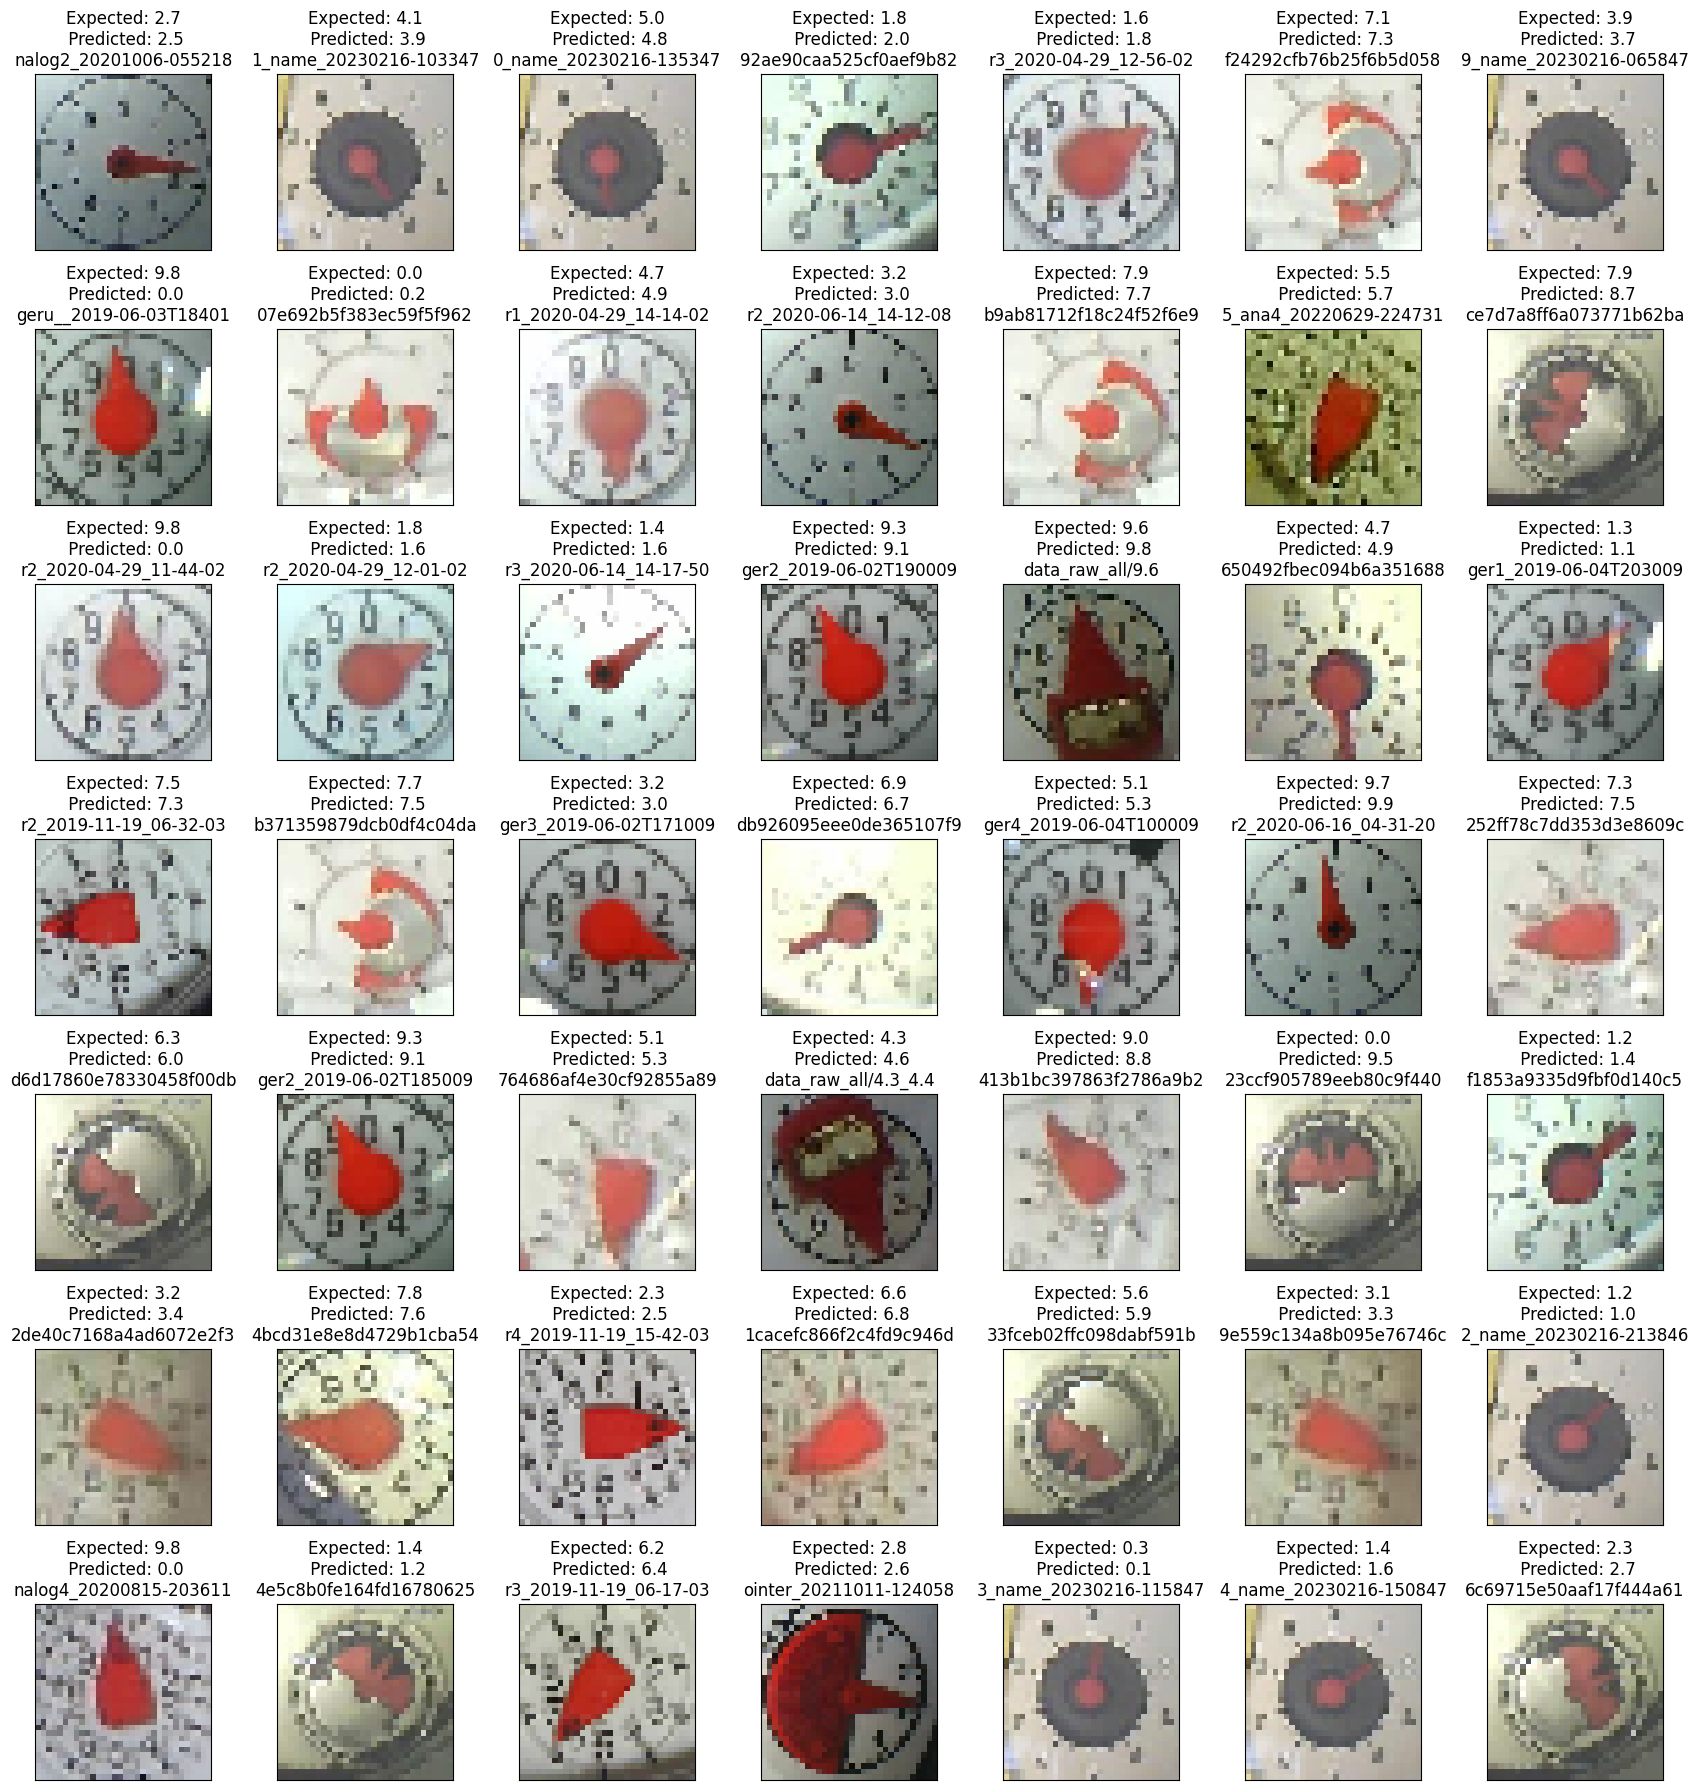

In [44]:
import numpy as np
from tensorflow import keras
import pandas as pd

max_delta=0.11

def plot_dataset(images, labels, columns=10, rows=5, figsize=(18, 10)):

    fig = plt.figure(figsize=figsize)
    
    for i in range(1, columns*rows +1):
        if (i>len(labels)):
            break
        fig.add_subplot(rows, columns, i)
        plt.title(labels[i-1])  # set title
        plt.imshow((images[i-1]).astype(np.uint8), aspect='1', extent=[0, 1, 0, 1])
        # yellow lines
        ax=plt.gca()
        ax.get_yaxis().set_visible(False) 
        ax.get_xaxis().set_visible(False) 
        
        plt.tight_layout()
    plt.show()

def plot_divergence(divergationset, title1, nb_classes):
    fig = plt.figure(figsize=(40, 10))
    fig.suptitle(title1)
    plt.bar(np.arange (0, nb_classes/10, 0.1), divergationset, width=0.09, align='center')
    plt.ylabel('count')
    plt.xlabel('digit class')
    plt.xticks(np.arange(0, nb_classes/10, 0.1))
    return fig

#model = keras.models.load_model(TFliteNamingAndVersion + "_best.h5")

classes = model.predict(x_data.astype(np.float32))
predictions = np.argmax(classes, axis=1).reshape(-1)/10

# 9.9 <> 0 = 0.1 and 1.1 <> 1.2 = 0.1
differences = np.minimum(np.abs(predictions-y_data), np.abs(predictions-(10-y_data)))
# used for filtering
false_differences = differences>max_delta
# only differences bigger than delta. so small differences can be ignored in early stages
false_predicted = differences[false_differences]
false_images = x_data[false_differences]
false_labels = [ "Expected: " + str(y1) + "\n Predicted: " + str(p) + "\n" + str(f)[-26:-4] for y1, p, f in zip(y_data[false_differences], predictions[false_differences], f_data[false_differences])]
false_files = [ f for f in  f_data[false_differences]]

print(f"Tested images: {len(y_data)}. {len(false_predicted)} false predicted. Accuracy is: {1-len(false_predicted)/len(y_data)}")
# plot the differences (max difference can only be 5.0)
plot_divergence(np.bincount(np.array(np.round(false_predicted*10)).astype(int), minlength=51), "Divergation of false predicted", 51)

# plot the false predicted images
plot_dataset(np.array(false_images), false_labels, columns=7, rows=7, figsize=(18,18))
#print(false_files)
fpf = pd.DataFrame(false_files)

# the csv can be used with collectmeterdigits to fix labels
# python3 -m collectmeteranalog  --labelfile=ana-class100_0166_s2_false_predicted.csv --model=ana-class100_0166_s2_q.tflite
fpf.to_csv(TFliteNamingAndVersion + '_false_predicted.csv')


### Save the model

* Save the model to the file with the "tflite" file format
* quantize the model and store it as -q.tflite

In [45]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpc4wpek2l/assets


INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpc4wpek2l/assets
2023-04-28 22:31:53.727644: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-28 22:31:53.727668: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-28 22:31:53.727758: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpc4wpek2l
2023-04-28 22:31:53.731360: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-28 22:31:53.731370: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpc4wpek2l
2023-04-28 22:31:53.744594: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-04-28 22:31:53.846904: I tensorflow/cc/saved_model/loader.cc:213] Running initialization

480284

In [46]:
from pathlib import Path
import tensorflow as tf

FileName = TFliteNamingAndVersion + "_q" + ".tflite"

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[n], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpsdomve_i/assets


INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpsdomve_i/assets
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-04-28 22:32:01.633194: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-28 22:32:01.633211: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


ana-class100_0168_s2_q.tflite


2023-04-28 22:32:01.633303: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpsdomve_i
2023-04-28 22:32:01.637092: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-28 22:32:01.637100: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpsdomve_i
2023-04-28 22:32:01.650596: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-04-28 22:32:01.755075: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpsdomve_i
2023-04-28 22:32:01.778553: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 145250 microseconds.
fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


136480